Predictor Training
==============

This notebook trains a model to learn the non-differentiable 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import cupyck
import primo.models
import primo.tools.sequences as seqtools
import primo.models.cas9 as cas9


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jhwzl7pj because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Reserve space on the GPU for running simulations. It's important to do this before running any tensorflow code (which will take all available GPU memory):

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [2]:
simulator = primo.models.Simulator()

Generate a large set of pairs with various Hamming distances, then simulate their query-target yields with NUPACK:

In [3]:
# Generate two random DNA sequences. First by creating a random sequence, then copying that sequence to another sequence, then mutating that second sequence at some given mutation rate, such that 
# the hamming distance between the sequences (i.e. how different they are) is sampled from a uniform distribution. This means that we could expect sequence that are nearly identical, and sequence pairs that are entirely opposite to occur at approximately the same rate. 
# Random_pairs: (arbitrary_sequence_1, arbitrary_sequence_2)

# Generate 5,000 of these arbitrary sequence pairs.
n_sequence_pairs_to_generate = 50000

# ...of length 80 nucleotides each (80 was chosen because that's the length of the DNA sequence's feature region in callie original paper).
sequence_length = 20

random_pairs, mut_rates = seqtools.random_mutant_pairs(n_sequence_pairs_to_generate, sequence_length)

In [4]:
# From here, we take the first arbitrary sequence, and its mutation (i.e. the random pairs), then we pretend that the first arbitrary sequence (i.e. at index 0) is a target DNA sequence, then we pretend the second arbitrary sequence (i.e. at index 1) is a query DNA sequences. 
seq_pairs = pd.DataFrame({
    "target_features": random_pairs[:, 0],
    "query_features": random_pairs[:, 1]
})

In [6]:
# Use NUPACK/CUPYCK to simulate the hybdrization yields of the two sequences in the pair (this is the Pink flow in the above diagram). 

# Note that this will not be used for Cas9 similarity search.
# Q: Why?
# A: This process of training a differentiable yield predictor from yields calculated by a *non*-differentiable yield simulator (i.e. NUPACK) is done becauase the non-differentiable simualtor is non-differentiable-- and therefore can't be used in a neural network (it would fail the backpropagation step).

# However, in Cas9 similarity search, we are predicting how well Cas9 will cut a target DNA sequence # using differentiable predictor provided by Finklestein lab called Nucleaseq (https://github.com/finkelsteinlab/nucleaseq) 

sim_results = simulator.simulate(seq_pairs)

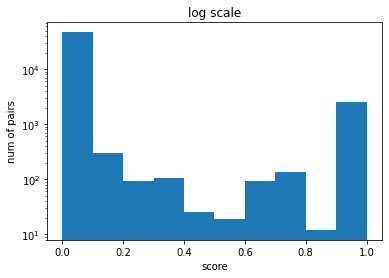

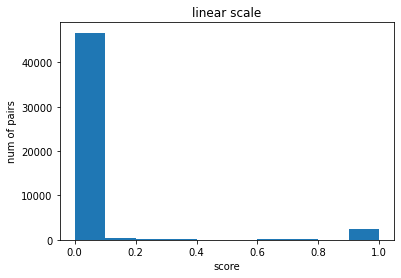

In [23]:
plt.hist(sim_results)
plt.title('log scale')
plt.yscale('log')
plt.xlabel('score')
plt.ylabel('num of pairs')
plt.show()


plt.hist(sim_results)
plt.title('linear scale')
plt.xlabel('score')
plt.ylabel('num of pairs')
plt.show()

Initialize a random predictor and train it on the sequences and simulated yields:

In [24]:
predictor = primo.models.PredictorModel()

In [27]:
onehot_seq_pairs = predictor.seq_pairs_to_onehots(seq_pairs)

In [32]:
history = predictor.train(onehot_seq_pairs, sim_results, epochs=50, validation_split = 0.2)

Epoch 1/50
1250/1250 [==============================] - 9s 5ms/step - loss: 0.1560 - val_loss: 0.1132
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0999 - val_loss: 0.0870
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0793 - val_loss: 0.0705
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0673 - val_loss: 0.0670
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0595 - val_loss: 0.0545
Epoch 6/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0546 - val_loss: 0.0521
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0508 - val_loss: 0.0487
Epoch 8/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0483 - val_loss: 0.0496
Epoch 9/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0464 - val_loss: 0.0424
Epoch 10/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.044

Visualize the model's accuracy by plotting the simulated yield against the pairwise Hamming distance, and coloring by the difference between the predicted yield and the simulated yield. The predictor should be most accurate along an S-shaped region in the center.

In [ ]:
pred_yield = predictor.model.predict(onehot_seq_pairs)

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(mut_rates, sim_results, c = np.abs(pred_yield.flatten() - sim_results))
plt.xlabel("Hamming distance")
plt.ylabel("Simulated yield")
plt.colorbar(label="|Simulated - Predicted|")

In [ ]:
errors = np.abs(pred_yield.flatten() - sim_results)
plt.figure()
plt.hist(errors)

Save the predictor for future training and use:

In [ ]:
#predictor.save('/tf/primo/data/models/yield-model.h5')